<a href="https://colab.research.google.com/github/ajuni-sohota/A-B-Testing-Fast-Food-Promotion/blob/main/A_B_Testing_FastFood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A/B Testing for Fast Food Promotions

# Part 1 - DEFINE

#### ---- 1 Define the problem ----


A fast-food chain is planning to add a new item to their menu, and they are deciding which promotion campaign to promote the latest products. The chain designs three campaigns and tests the effects of each promotion by assigning one type to each store.

In this project, A/B testing with ANOVA is used to determine which advertising works the best.

We find that promotions 1 and 3 work better than the second promotion across all the market sizes. Also, there is no difference in the mean of sales generated by the first and third promotions. Thus we recommend these two to the chain to promote their new products in all types of stores.

## Part 2 - DISCOVER
#### ---- 2 Load the data ----

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Load libraries
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import squarify

In [ ]:
 pip install squarify

In [ ]:
df = pd.read_csv('WA_Marketing-Campaign.csv')
df.head(5)

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


#### ---- 3 Clean the data ----

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


In [ ]:
df.describe()

,MarketID,LocationID,AgeOfStore,Promotion,week,SalesInThousands
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,5.715328,479.656934,8.503650,2.029197,2.500000,53.466204
std,2.877001,287.973679,6.638345,0.810729,1.119055,16.755216
min,1.000000,1.000000,1.000000,1.000000,1.000000,17.340000
25%,3.000000,216.000000,4.000000,1.000000,1.750000,42.545000
50%,6.000000,504.000000,7.000000,2.000000,2.500000,50.200000
75%,8.000000,708.000000,12.000000,3.000000,3.250000,60.477500
max,10.000000,920.000000,28.000000,3.000000,4.000000,99.650000


In [ ]:
df.drop_duplicates()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81
...,...,...,...,...,...,...,...
543,10,Large,919,2,1,4,64.34
544,10,Large,920,14,2,1,50.20
545,10,Large,920,14,2,2,45.75
546,10,Large,920,14,2,3,44.29


#### ---- 4 Explore the data (EDA) ----

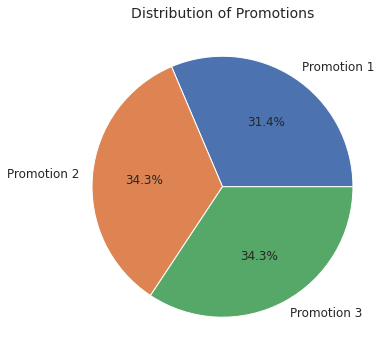

In [ ]:
# Explore the distribution of promotion
sns.set_theme()
plt.figure(figsize=(6,6))
pie_labels = ['Promotion 1', 'Promotion 2', 'Promotion 3']
plt.pie(df.groupby(['Promotion']).size().to_list(), 
        labels=pie_labels, autopct='%1.1f%%',textprops={'fontsize': 12})
plt.title('Distribution of Promotions', fontsize=14)
plt.show()

Promotion 1 and 2 have a higher weight of outreach but we will see if that makes a big difference since each promotion is roughly 1/3 of the total distribution.


In [ ]:
#### Summary of EDA/Data Cleaning:


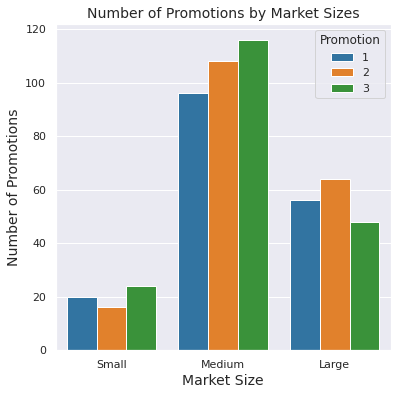

In [ ]:
# Explore the promotion with different market sizes
df_bar = df.groupby(['Promotion','MarketSize']).size().to_frame().reset_index()
df_bar.rename({0:'NumOfStore'}, axis=1, inplace=True)

sns.set_theme()
plt.figure(figsize=(6,6))
ax = sns.barplot(x='MarketSize', y='NumOfStore',hue='Promotion', 
                 data=df_bar, hue_order=[1,2,3], palette='tab10', order=['Small', 'Medium','Large'])
# ax.set(xlabel='Promotion Type', ylabel='Number of Stores', fontsize=18)
plt.xlabel('Market Size', fontsize=14)
plt.ylabel('Number of Promotions', fontsize=14)
plt.legend(title='Promotion')
plt.title('Number of Promotions by Market Sizes', fontsize=14)
plt.show()

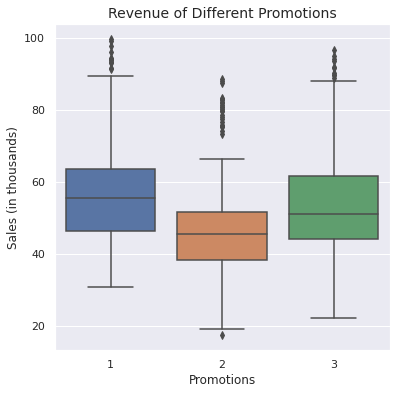

In [ ]:
# Explore the sales with promotion and market sizes
fig= plt.figure(figsize=(6,6))
# ax = sns.displot(x="SalesInThousands", data=df, hue='MarketSize',
#                  col='Promotion', kind='kde', col_order=[1,2,3], hue_order=['Small','Medium','Large'])

ax = sns.boxplot(y="SalesInThousands", data=df, x='Promotion', 
                 order =[1,2,3])
ax.set_ylabel('Sales (in thousands)')
ax.set_xlabel('Promotions')
ax.set_title('Revenue of Different Promotions', fontsize=14)
plt.show()

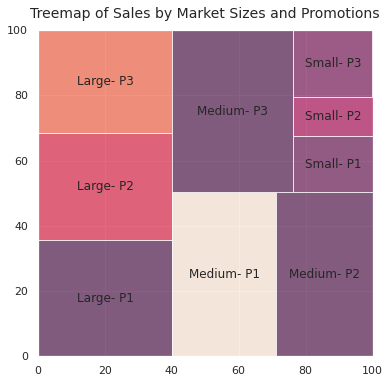

In [ ]:
treemap = df.groupby(['MarketSize','Promotion'])['SalesInThousands'].sum().to_frame().reset_index()
treemap['Market-Promotion'] = treemap['MarketSize'].astype(str) + '- P' + treemap['Promotion'].astype(str)
fig = plt.figure(figsize=(6,6))
squarify.plot(sizes=treemap['SalesInThousands'], label=treemap['Market-Promotion'], alpha=.7)
plt.title("Treemap of Sales by Market Sizes and Promotions", fontsize =14, pad=12)
plt.show()

In [ ]:
# Check each promotion's mean in sales and group them together
df.groupby('Promotion')['SalesInThousands'].mean()


Promotion
1    58.099012
2    47.329415
3    55.364468
Name: SalesInThousands, dtype: float64

#### ---- 5 ANOVA & TUKEY ----

* Performing ANOVA tests for all market sizes for each promotion (p1, p2, p3) using stats.f_oneway which.

* The one-way ANOVA tests the null hypothesis that two or more groups have the 
same population mean. The test is applied to samples from two or more groups, possibly with differing sizes.

In [ ]:
p1_sale = df[df['Promotion'] == 1]['SalesInThousands']
p2_sale = df[df['Promotion'] == 2]['SalesInThousands']
p3_sale = df[df['Promotion'] == 3]['SalesInThousands']

In [ ]:
stats.f_oneway(p1_sale, p2_sale, p3_sale)

F_onewayResult(statistic=21.953485793080677, pvalue=6.765849261408714e-10)

* This ANOVA f-statistic is 21.95 with a p-value of 6.77 and is an indication that the promotions, regardless of market size, have a positive effect on the revenue this fast food restaurant will make for each promotion. 

* A tukey test will be performed for each of these promotions with regardless of market size

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-10.7696,0.001,-14.774,-6.7652,True
1,3,-2.7345,0.2447,-6.7389,1.2698,False
2,3,8.0351,0.001,4.1207,11.9494,True


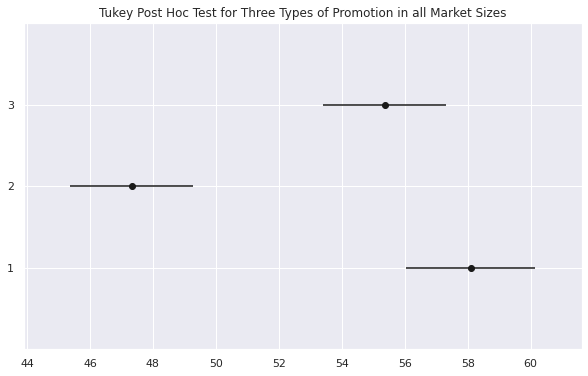

In [ ]:
tukey = pairwise_tukeyhsd(endog=df['SalesInThousands'],     
                          groups=df['Promotion'],   
                          alpha=0.05)          

tukey.plot_simultaneous()    
# plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red")
plt.title("Tukey Post Hoc Test for Three Types of Promotion in all Market Sizes")
tukey.summary()   

Tukey test shows us that Promotion 1 and 3 have no statistical difference between each other but that Promotion 1 and 2/ Promotion 1 and 3 do have a statistical difference in revenue generation.


#### ---- 6 Hypothesize Other Factors ----



*   Will perform ANOVA & Tukey for each promotion but by market size to see if this could be a component to focus on for each promotion.



### Part 3 - DEVELOP

#### ---- 7 Engineer features  ----


In [ ]:
# Data preparation for market sizes

df['market-promotion'] = df['MarketSize'].astype(str) + '-' + df['Promotion'].astype(str)
df.head(3)

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands,market-promotion
0,1,Medium,1,4,3,1,33.73,Medium-3
1,1,Medium,1,4,3,2,35.67,Medium-3
2,1,Medium,1,4,3,3,29.03,Medium-3


In [ ]:
# Group each by market size

small1 = df.loc[(df['market-promotion']=='Small-1'), 'SalesInThousands']
small2 = df.loc[(df['market-promotion']=='Small-2'), 'SalesInThousands']
small3 = df.loc[(df['market-promotion']=='Small-3'), 'SalesInThousands']

medium1 = df.loc[(df['market-promotion']=='Medium-1'), 'SalesInThousands']
medium2 = df.loc[(df['market-promotion']=='Medium-2'), 'SalesInThousands']
medium3 = df.loc[(df['market-promotion']=='Medium-3'), 'SalesInThousands']

large1 = df.loc[(df['market-promotion']=='Large-1'), 'SalesInThousands']
large2 = df.loc[(df['market-promotion']=='Large-2'), 'SalesInThousands']
large3 = df.loc[(df['market-promotion']=='Large-3'), 'SalesInThousands']


#### ---- 8 Create & Test models ----


**Small Market Analysis**

In [ ]:
stats.f_oneway(small1, small2, small3)  


F_onewayResult(statistic=16.57648112557373, pvalue=2.115939995841426e-06)

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-9.3519,0.001,-13.6829,-5.0208,True
1,3,-0.6483,0.9,-4.5579,3.2612,False
2,3,8.7035,0.001,4.536,12.8711,True


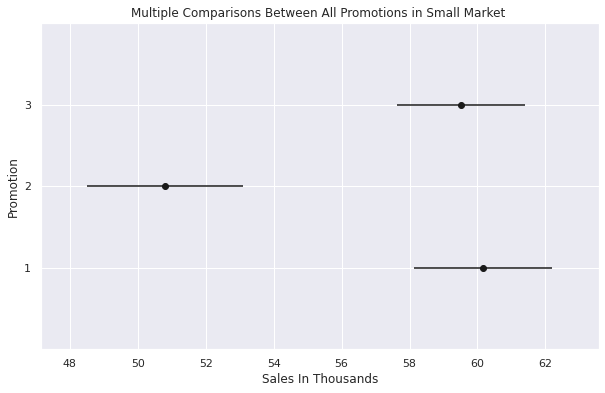

In [ ]:
small = df.loc[df['MarketSize'] == 'Small', :]

tukey_small = pairwise_tukeyhsd(endog=small['SalesInThousands'],  
                          groups=small['Promotion'],   
                          alpha=0.05)  

tukey_small.plot_simultaneous()    
plt.title("Multiple Comparisons Between All Promotions in Small Market ")
plt.xlabel("Sales In Thousands")
plt.ylabel("Promotion")
# plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red")

tukey_small.summary()

**Medium Market Analysis**

In [ ]:
stats.f_oneway(medium1, medium2, medium3)  

F_onewayResult(statistic=29.68813375084531, pvalue=1.5197404971604578e-12)

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-8.5583,0.001,-11.3108,-5.8057,True
1,3,-2.2037,0.1356,-4.9113,0.5038,False
2,3,6.3545,0.001,3.7306,8.9785,True


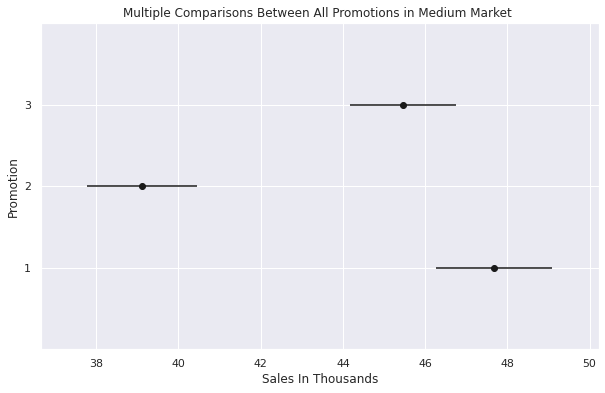

In [ ]:
medium = df.loc[df['MarketSize'] == 'Medium', :]
tukey_medium = pairwise_tukeyhsd(endog=medium['SalesInThousands'],  
                          groups=medium['Promotion'],   
                          alpha=0.05)  

tukey_medium.plot_simultaneous()    
plt.title("Multiple Comparisons Between All Promotions in Medium Market ")
plt.xlabel("Sales In Thousands")
plt.ylabel("Promotion")
# plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red")

tukey_medium.summary()  

**Large Market Analysis**

In [ ]:
stats.f_oneway(large1, large2, large3)  


F_onewayResult(statistic=21.44511115677835, pvalue=5.261567483455427e-09)

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-14.9139,0.001,-21.5284,-8.2993,True
1,3,1.9681,0.7701,-5.1424,9.0785,False
2,3,16.8819,0.001,9.9797,23.7842,True


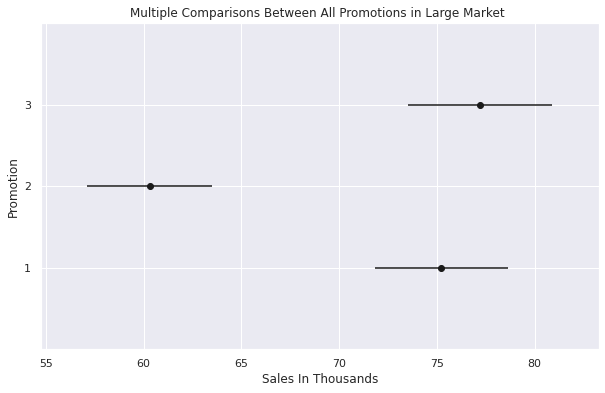

In [ ]:
large = df.loc[df['MarketSize'] == 'Large', :]

tukey_large = pairwise_tukeyhsd(endog=large['SalesInThousands'],  
                          groups=large['Promotion'],   
                          alpha=0.05)  

tukey_large.plot_simultaneous()    
plt.title("Multiple Comparisons Between All Promotions in Large Market ")
plt.xlabel("Sales In Thousands")
plt.ylabel("Promotion")
# plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red")

tukey_large.summary() 

#### ---- 9 Select best model  ----

All models tested result in same result.

### Part 4 - DEPLOY

#### ---- 10 Deploy solution & Summary ----

Although necessary to explore, the market size for each promotion location did not effect the end result which is that promotion 1 and 3 will result in higher revenue than Promotion 2 if implemented. Promotion 1 and 3 are not statistically different than each other, so the fast-food chain could implement both and would still result in a higher revenue. We can see that promotion 1 and 3 outperform differently for each market size, but are still not  statistically different from one another in performance. I would reject Promotion 2 as a viable option. 